In [2]:
#!/usr/bin/env python
import os, glob
from nilearn import image
from nilearn import plotting
import numpy as np
import pandas as pd

In [2]:
def utils_extract_schaefer2018(nifti_fname_dict):
    # parameters
    # ==========
    #   nifti_fname: 
    # result
    # ======
    # run them through nifti masker
    import argparse
    import numpy as np
    import os, glob
    import pandas as pd
    from nilearn import image
    from nilearn.maskers import NiftiLabelsMasker
    from nilearn import datasets

    singletrial_dir = nifti_fname_dict['singletrial_dir']; sub = nifti_fname_dict['sub'];
    ses = nifti_fname_dict['ses']; run = nifti_fname_dict['run']; runtype = nifti_fname_dict['runtype']; event = nifti_fname_dict['event'];

    img_flist = glob.glob(os.path.join(singletrial_dir, sub, f'{sub}_{ses}_{run}_{runtype}_event-{event}_trial-*.nii.gz'))
    img_flist = sorted(img_flist)

    stacked_singletrial = image.concat_imgs(sorted(img_flist))

    dataset = datasets.fetch_atlas_schaefer_2018()
    atlas_filename = dataset.maps
    # labels = dataset.labels
    labels = np.insert(dataset.labels, 0, 'Background')
    masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                            memory='nilearn_cache', verbose=5)
    time_series = masker.fit_transform(stacked_singletrial) # (trials, parcels)
    labels_utfstring = [x.decode('utf-8')  for x in labels[1:] ]
    singletrial_vstack_beta = pd.DataFrame(time_series, columns = labels_utfstring)
    flist_basename = [os.path.basename(m) for m in sorted(img_flist)]
    singletrial_vstack_beta.insert(0, 'singletrial_fname', flist_basename)
    return singletrial_vstack_beta

In [6]:
# 1. load nifti image
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/'
sub = 'sub-0030'; ses = 'ses-01'; run = '*'; runtype = 'pain'; event = 'stimulus'
img_flist = glob.glob(os.path.join(singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-{event}*.nii.gz'))
print(img_flist[0:10])
img_flist = sorted(img_flist)
stacked_singletrial = image.concat_imgs(sorted(img_flist))


['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-003_cuetype-high_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-011_cuetype-high_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-010_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-sti

/Users/h/anaconda3/envs/spacetop_datalad/lib/python3.9/site-packages/numpy/ma/core.py:2829: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


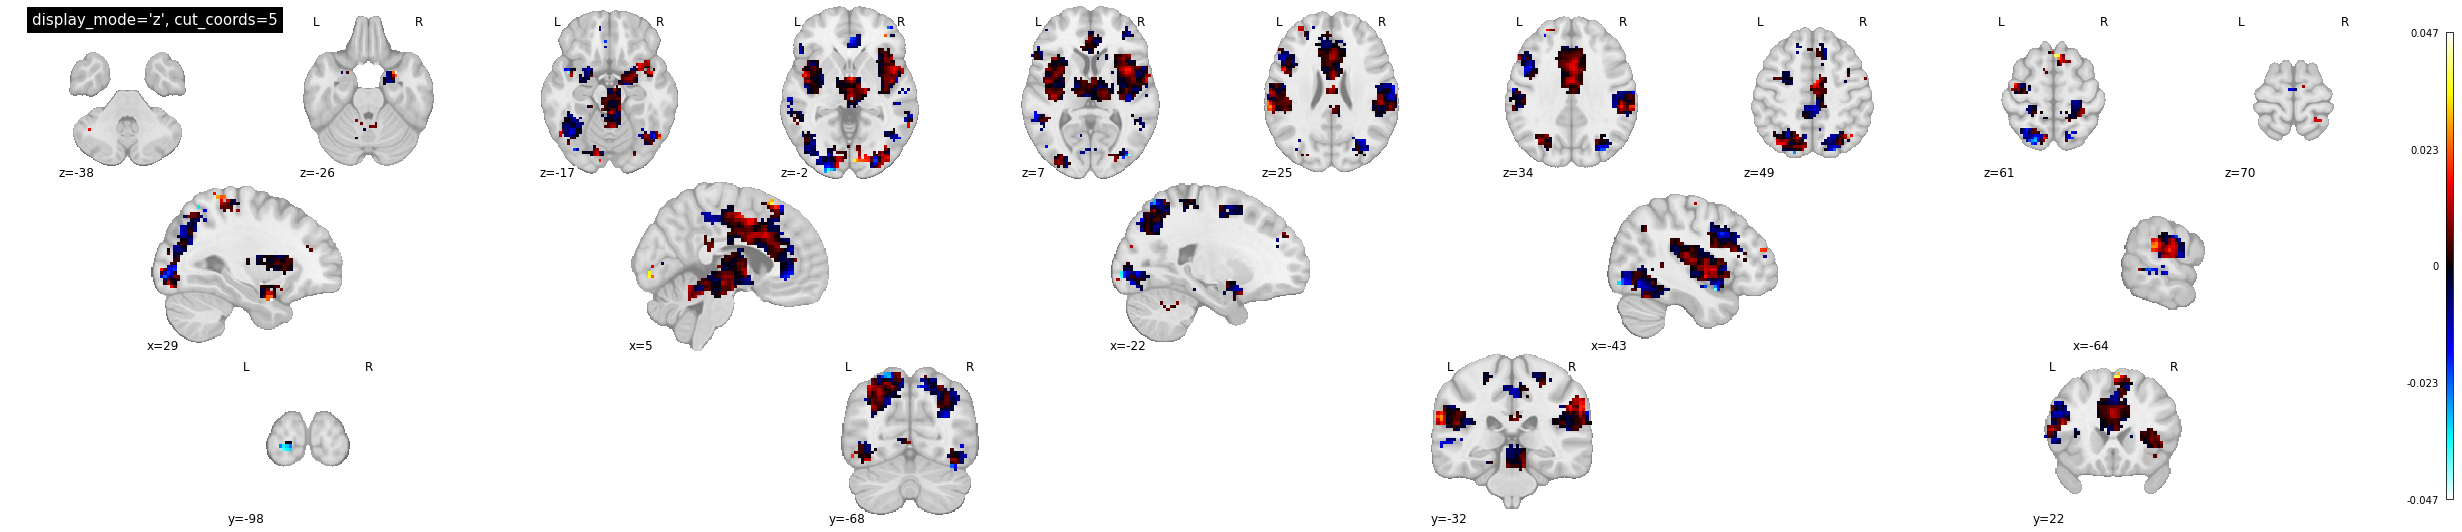

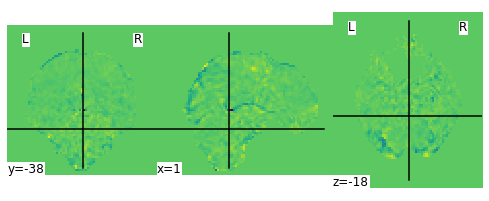

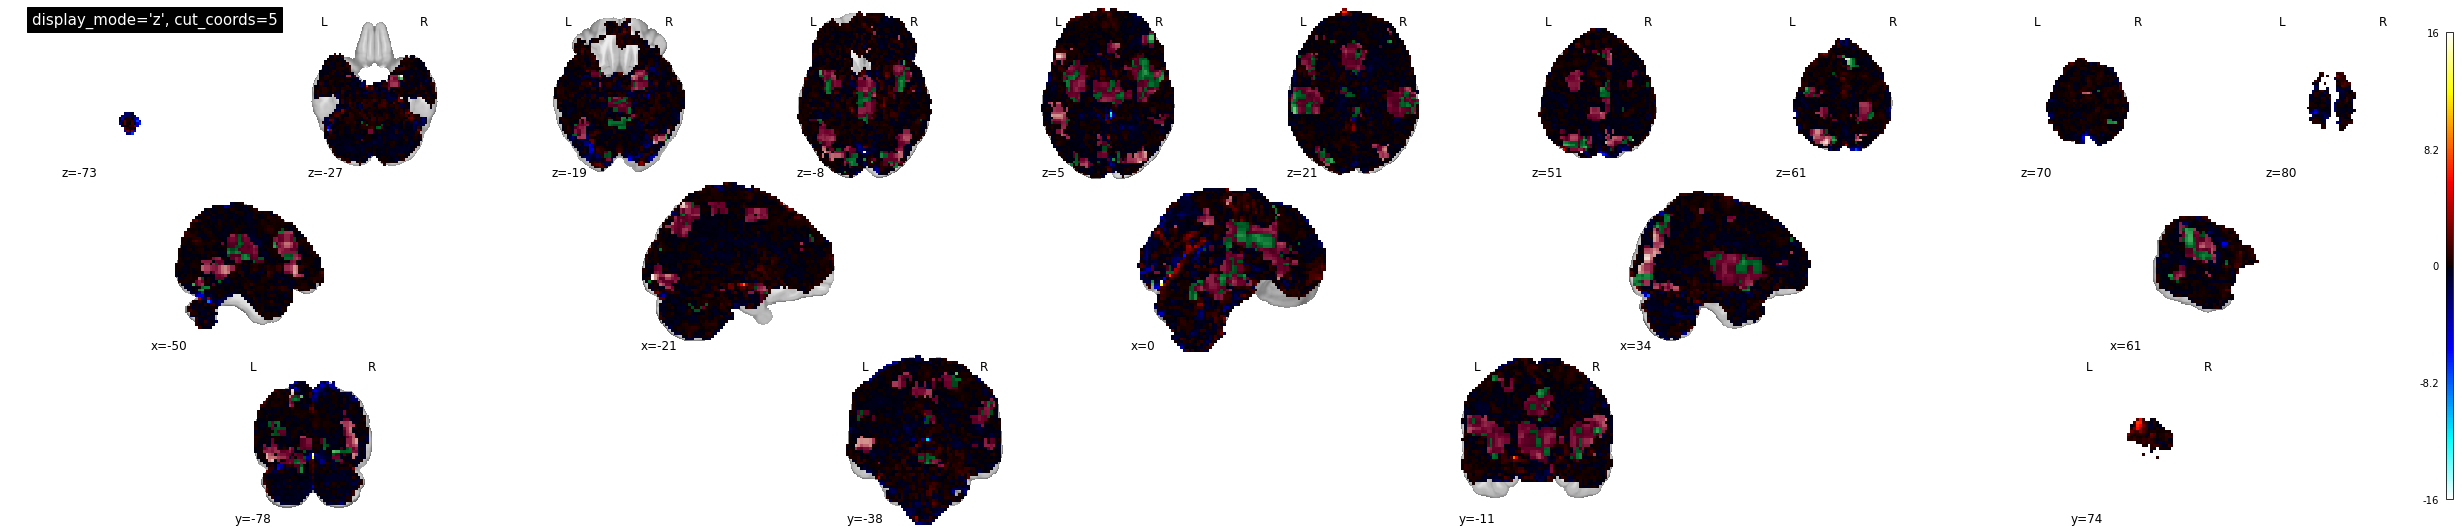

In [7]:
# 3. resample space
nps = '/Users/h/Documents/MATLAB/MasksPrivate/Masks_private/2013_Wager_NEJM_NPS/weights_NSF_grouppred_cvpcr.nii.gz'
nps_img = image.load_img(nps)

plotting.plot_stat_map(nps_img,display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")
plotting.plot_img(image.mean_img(stacked_singletrial))
# %% resample space
resampled_nps = image.resample_img(nps_img, 
                                   target_affine = stacked_singletrial.affine, 
                                   target_shape = stacked_singletrial.shape[0:3],
                                   interpolation = 'continuous')

# %% check: plot resampled
display = plotting.plot_stat_map(image.mean_img(stacked_singletrial),display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")
display.add_overlay(resampled_nps,cmap=plotting.cm.purple_green)



In [9]:
# %% apply nps
nps_array = image.get_data(resampled_nps)
singletrial_array = image.get_data(stacked_singletrial)
len_singletrialstack = singletrial_array.shape[-1]
vectorize_singletrial = singletrial_array.reshape(np.prod(list(singletrial_array.shape[0:3])),len_singletrialstack )
nps_extract = np.dot(nps_array.reshape(-1), vectorize_singletrial)
nps_df = pd.DataFrame({'singletrial_fname': [os.path.basename(basename) for basename in img_flist], 'nps': nps_extract})
nps_df.head()

,singletrial_fname,nps
0,sub-0030_ses-01_run-03_runtype-pain_event-stim...,14.279780
1,sub-0030_ses-01_run-03_runtype-pain_event-stim...,2.128011
2,sub-0030_ses-01_run-03_runtype-pain_event-stim...,5.970292
3,sub-0030_ses-01_run-03_runtype-pain_event-stim...,2.582800
4,sub-0030_ses-01_run-03_runtype-pain_event-stim...,4.071396


# version 2

In [ ]:
def utils_extractsignature(img_flist, signature_dict, signature_key, brain_mask_path):
    """
    Using signature_dict, select a signature to apply onto img_flist and return the dot product between the signature and each Nifti image.
    This version resamples images to a brain mask and captures the intersection before dot product calculation.

    Args:
        img_flist (list): List of Nifti filepaths.
        signature_dict (dict): Dictionary with signature names as keys and signature paths as values.
        signature_key (str): Name of the signature.
        brain_mask_path (str): Filepath to the brain mask Nifti image.

    Returns:
        pd.DataFrame: Table with signature-extracted dot products.
    """
    import os
    from nilearn import image
    import pandas as pd
    import numpy as np

    # Load brain mask and prepare for resampling
    brain_mask_img = image.load_img(brain_mask_path)

    # Prepare the signature image
    signature_path = signature_dict.get(signature_key)
    if not signature_path:
        raise ValueError(f"Signature '{signature_key}' not found in signature_dict.")
    signature_img = image.load_img(signature_path)

    # Resample signature to the brain mask
    resampled_signature = image.resample_to_img(source_img=signature_img, target_img=brain_mask_img, interpolation='nearest')

    # Initialize list to store dot products
    dot_products = []

    # Process each image in the file list
    for img_path in sorted(img_flist):
        img = image.load_img(img_path)

        # Resample image to the brain mask
        resampled_img = image.resample_to_img(source_img=img, target_img=brain_mask_img, interpolation='linear')

        # Mask both the resampled image and signature to only consider the overlapping voxels
        masked_img_data = resampled_img.get_fdata()[brain_mask_img.get_fdata() > 0]
        masked_signature_data = resampled_signature.get_fdata()[brain_mask_img.get_fdata() > 0]

        # Calculate dot product for the current image
        dot_product = np.dot(masked_img_data.flatten(), masked_signature_data.flatten())
        dot_products.append(dot_product)

    # Create a DataFrame to return results
    results_df = pd.DataFrame({
        "singletrial_fname": [os.path.basename(path) for path in img_flist],
        f"{signature_key}_dot_product": dot_products
    })

    return results_df


In [18]:
brain_mask_img = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')

# Prepare the signature image
# signature_path = signature_dict.get(signature_key)
# if not signature_path:
#     raise ValueError(f"Signature '{signature_key}' not found in signature_dict.")
# signature_img = image.load_img(signature_path)
nps = '/Users/h/Documents/MATLAB/MasksPrivate/Masks_private/2013_Wager_NEJM_NPS/weights_NSF_grouppred_cvpcr.nii.gz'
signature_img = image.load_img(nps)
# Resample signature to the brain mask
resampled_signature = image.resample_to_img(source_img=signature_img, target_img=brain_mask_img, interpolation='nearest')


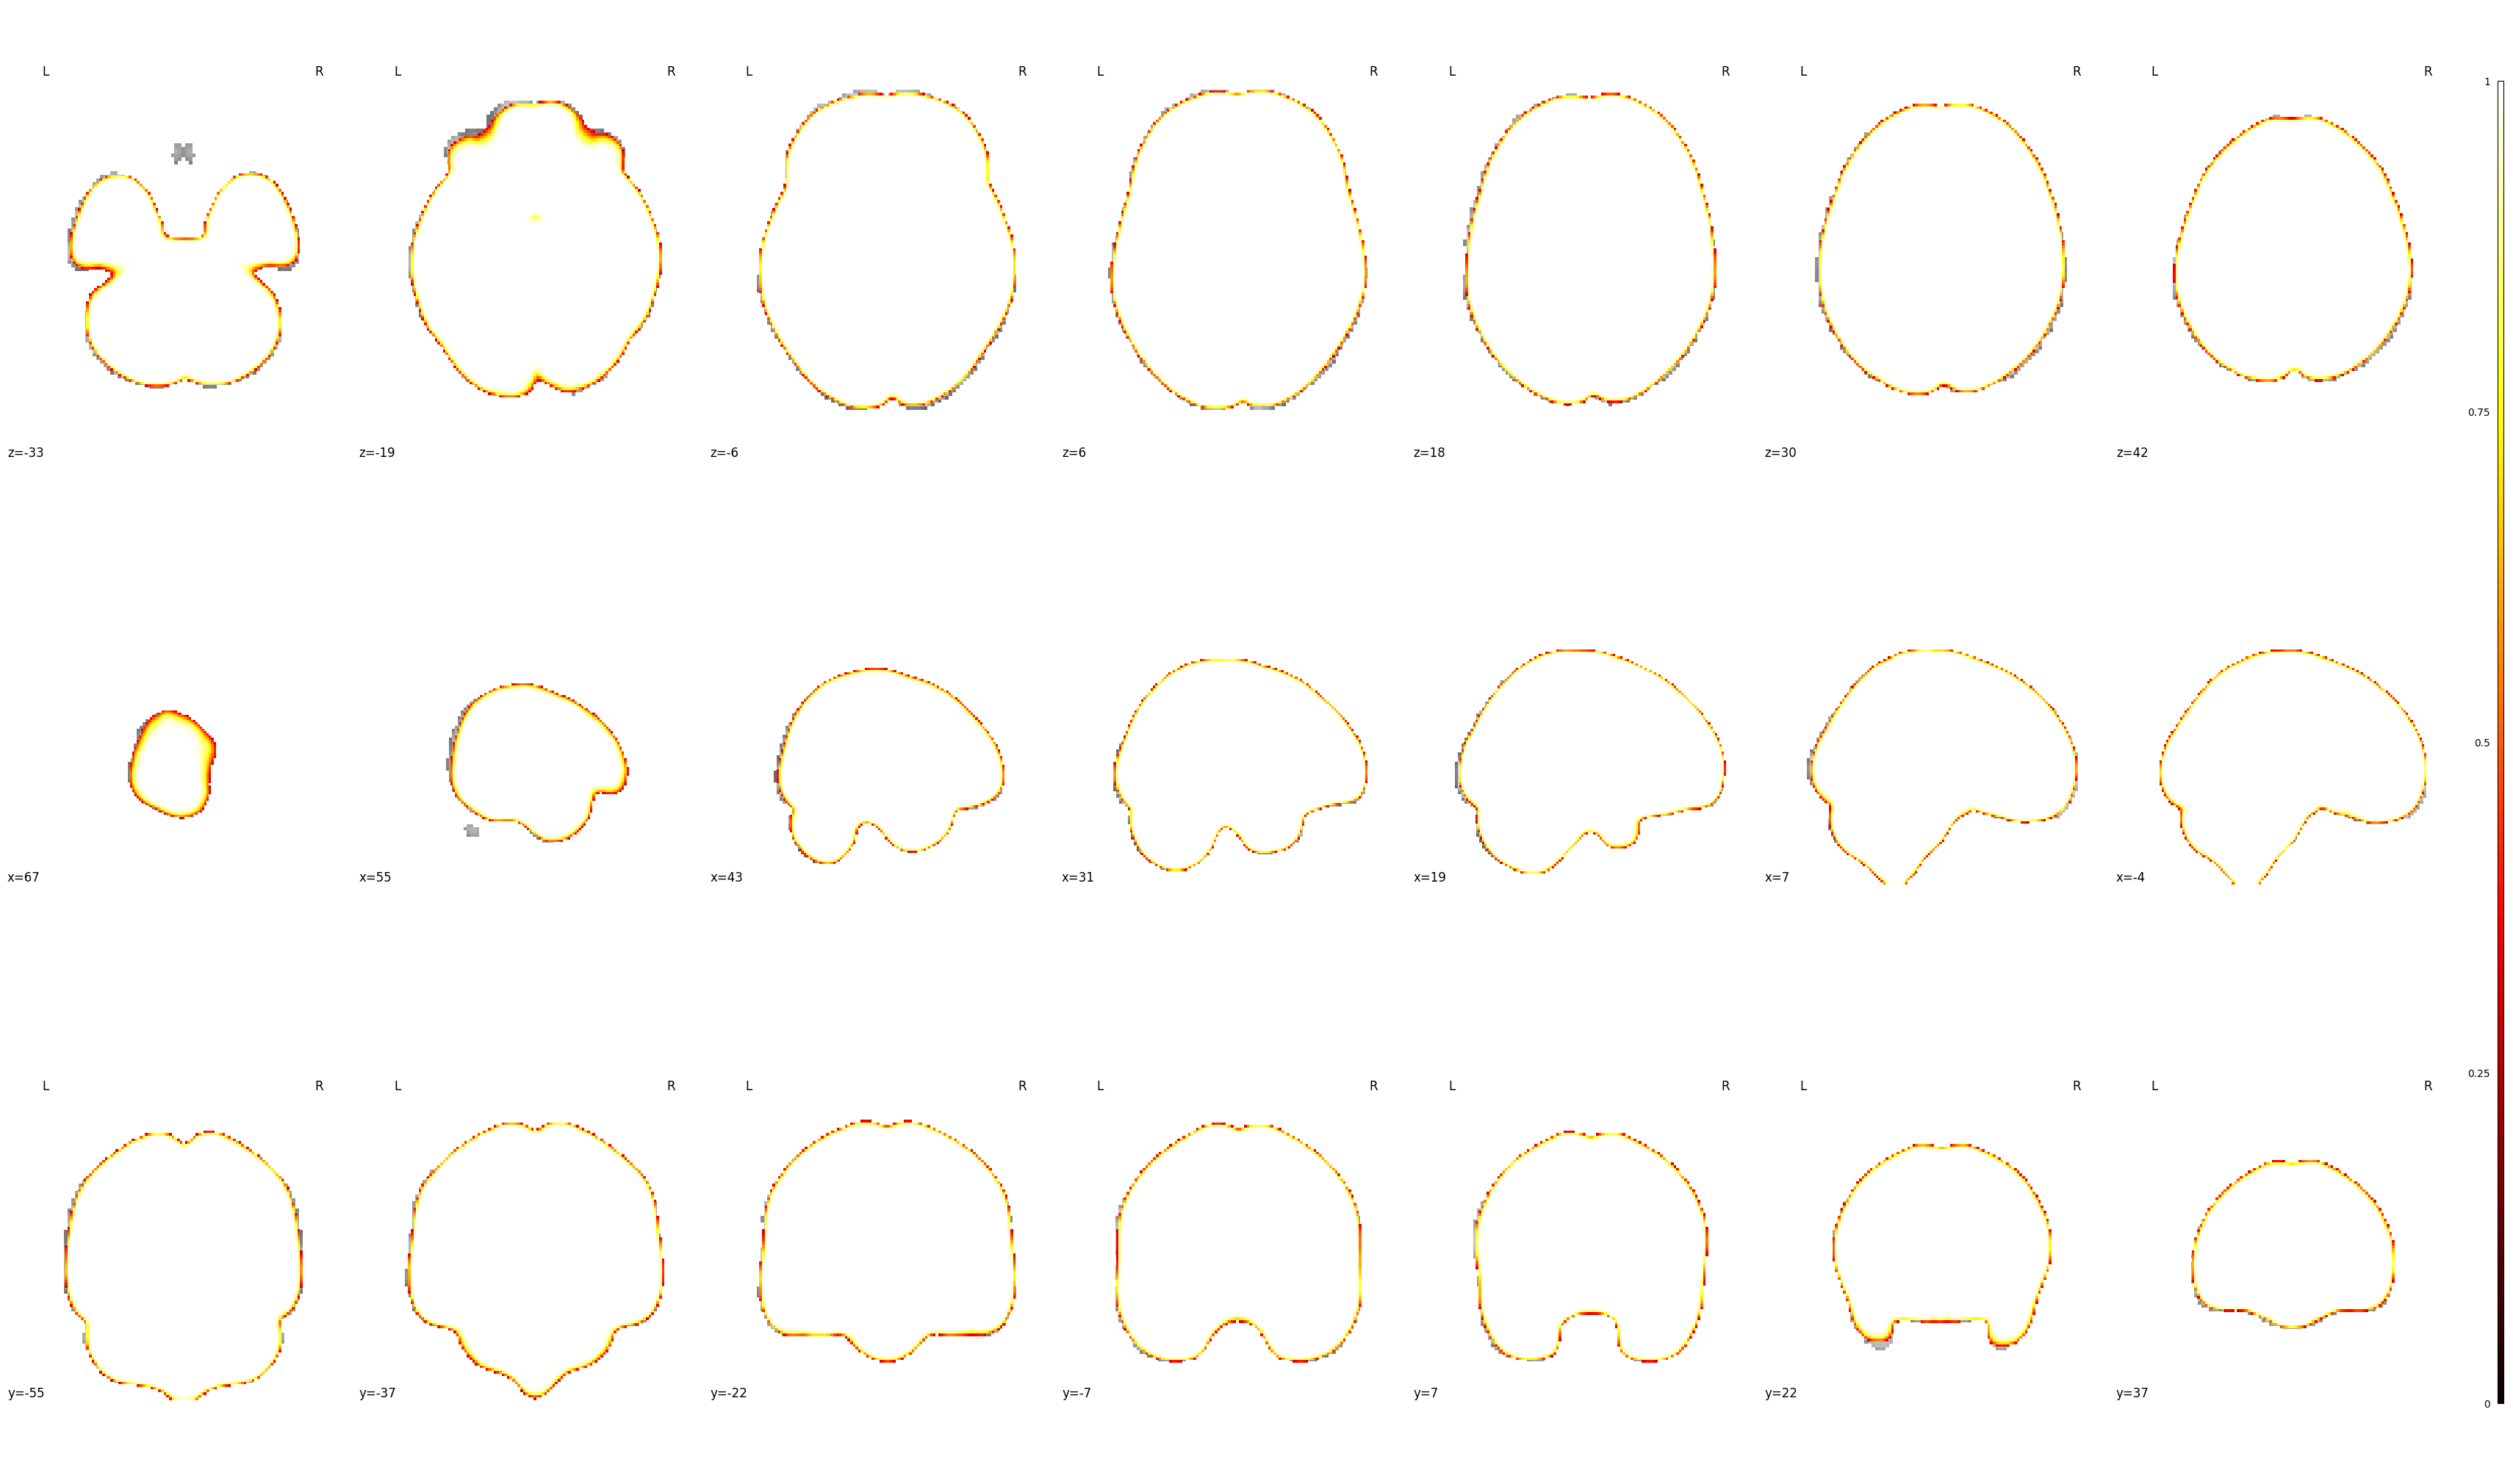

In [27]:
brain_mask_img = image.load_img('/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
plotting.plot_stat_map(brain_mask_img, display_mode='mosaic')

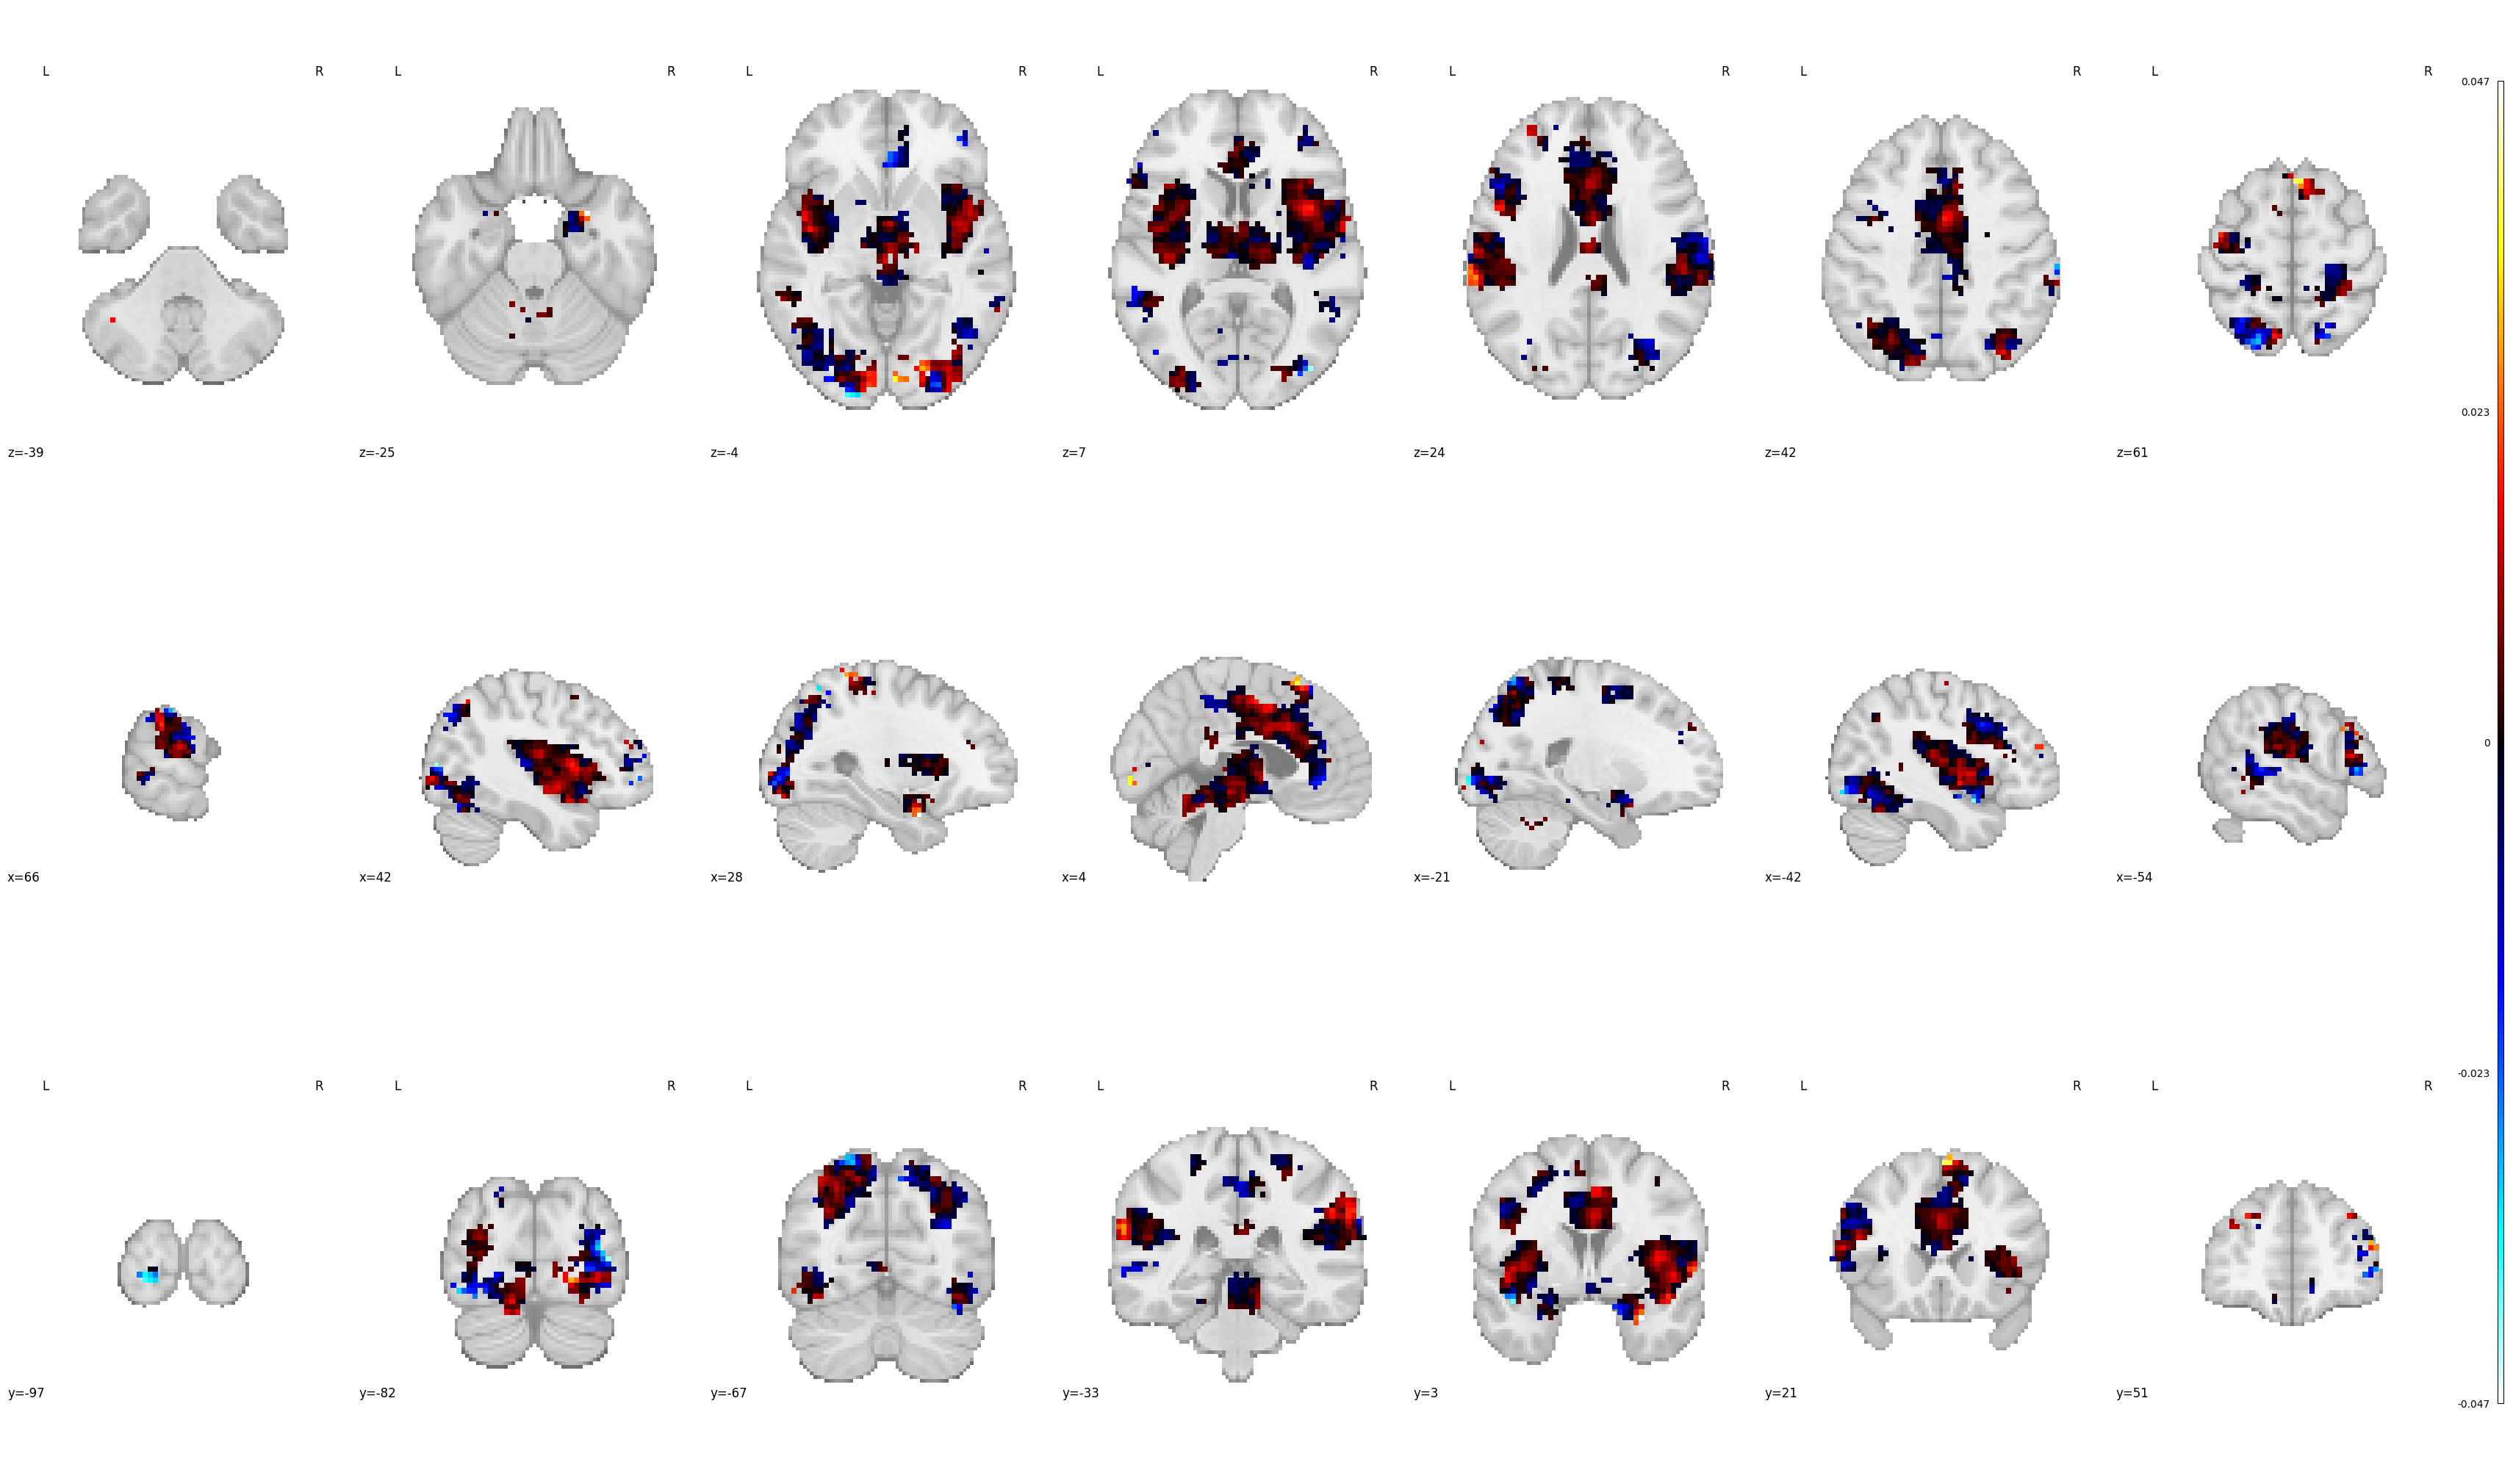

In [19]:
plotting.plot_stat_map(resampled_signature, display_mode='mosaic')

In [20]:
# 1. load nifti image
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/'
sub = 'sub-0030'; ses = 'ses-01'; run = '*'; runtype = 'pain'; event = 'stimulus'
img_flist = glob.glob(os.path.join(singletrial_dir, sub, f'{sub}_{ses}_{run}_runtype-{runtype}_event-{event}*.nii.gz'))
print(img_flist[0:10])
img_flist = sorted(img_flist)
# stacked_singletrial = image.concat_imgs(sorted(img_flist))

dot_products = []

# Process each image in the file list
for img_path in sorted(img_flist):
    img = image.load_img(img_path)

    # Resample image to the brain mask
    resampled_img = image.resample_to_img(source_img=img, target_img=brain_mask_img, interpolation='nearest')

    # Mask both the resampled image and signature to only consider the overlapping voxels
    masked_img_data = resampled_img.get_fdata()[brain_mask_img.get_fdata() > 0]
    masked_signature_data = resampled_signature.get_fdata()[brain_mask_img.get_fdata() > 0]

    # Calculate dot product for the current image
    dot_product = np.dot(masked_img_data.flatten(), masked_signature_data.flatten())
    dot_products.append(dot_product)


['/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-003_cuetype-high_stimintensity-low.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-011_cuetype-high_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-med.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0030/sub-0030_ses-01_run-03_runtype-pain_event-stimulus_trial-002_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupplateau/sub-0030/sub-0030_ses-01_run-06_runtype-pain_event-stimulus_trial-010_cuetype-low_stimintensity-high.nii.gz', '/Volumes/spacetop_projects_cue/analysis/fmri/nile

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


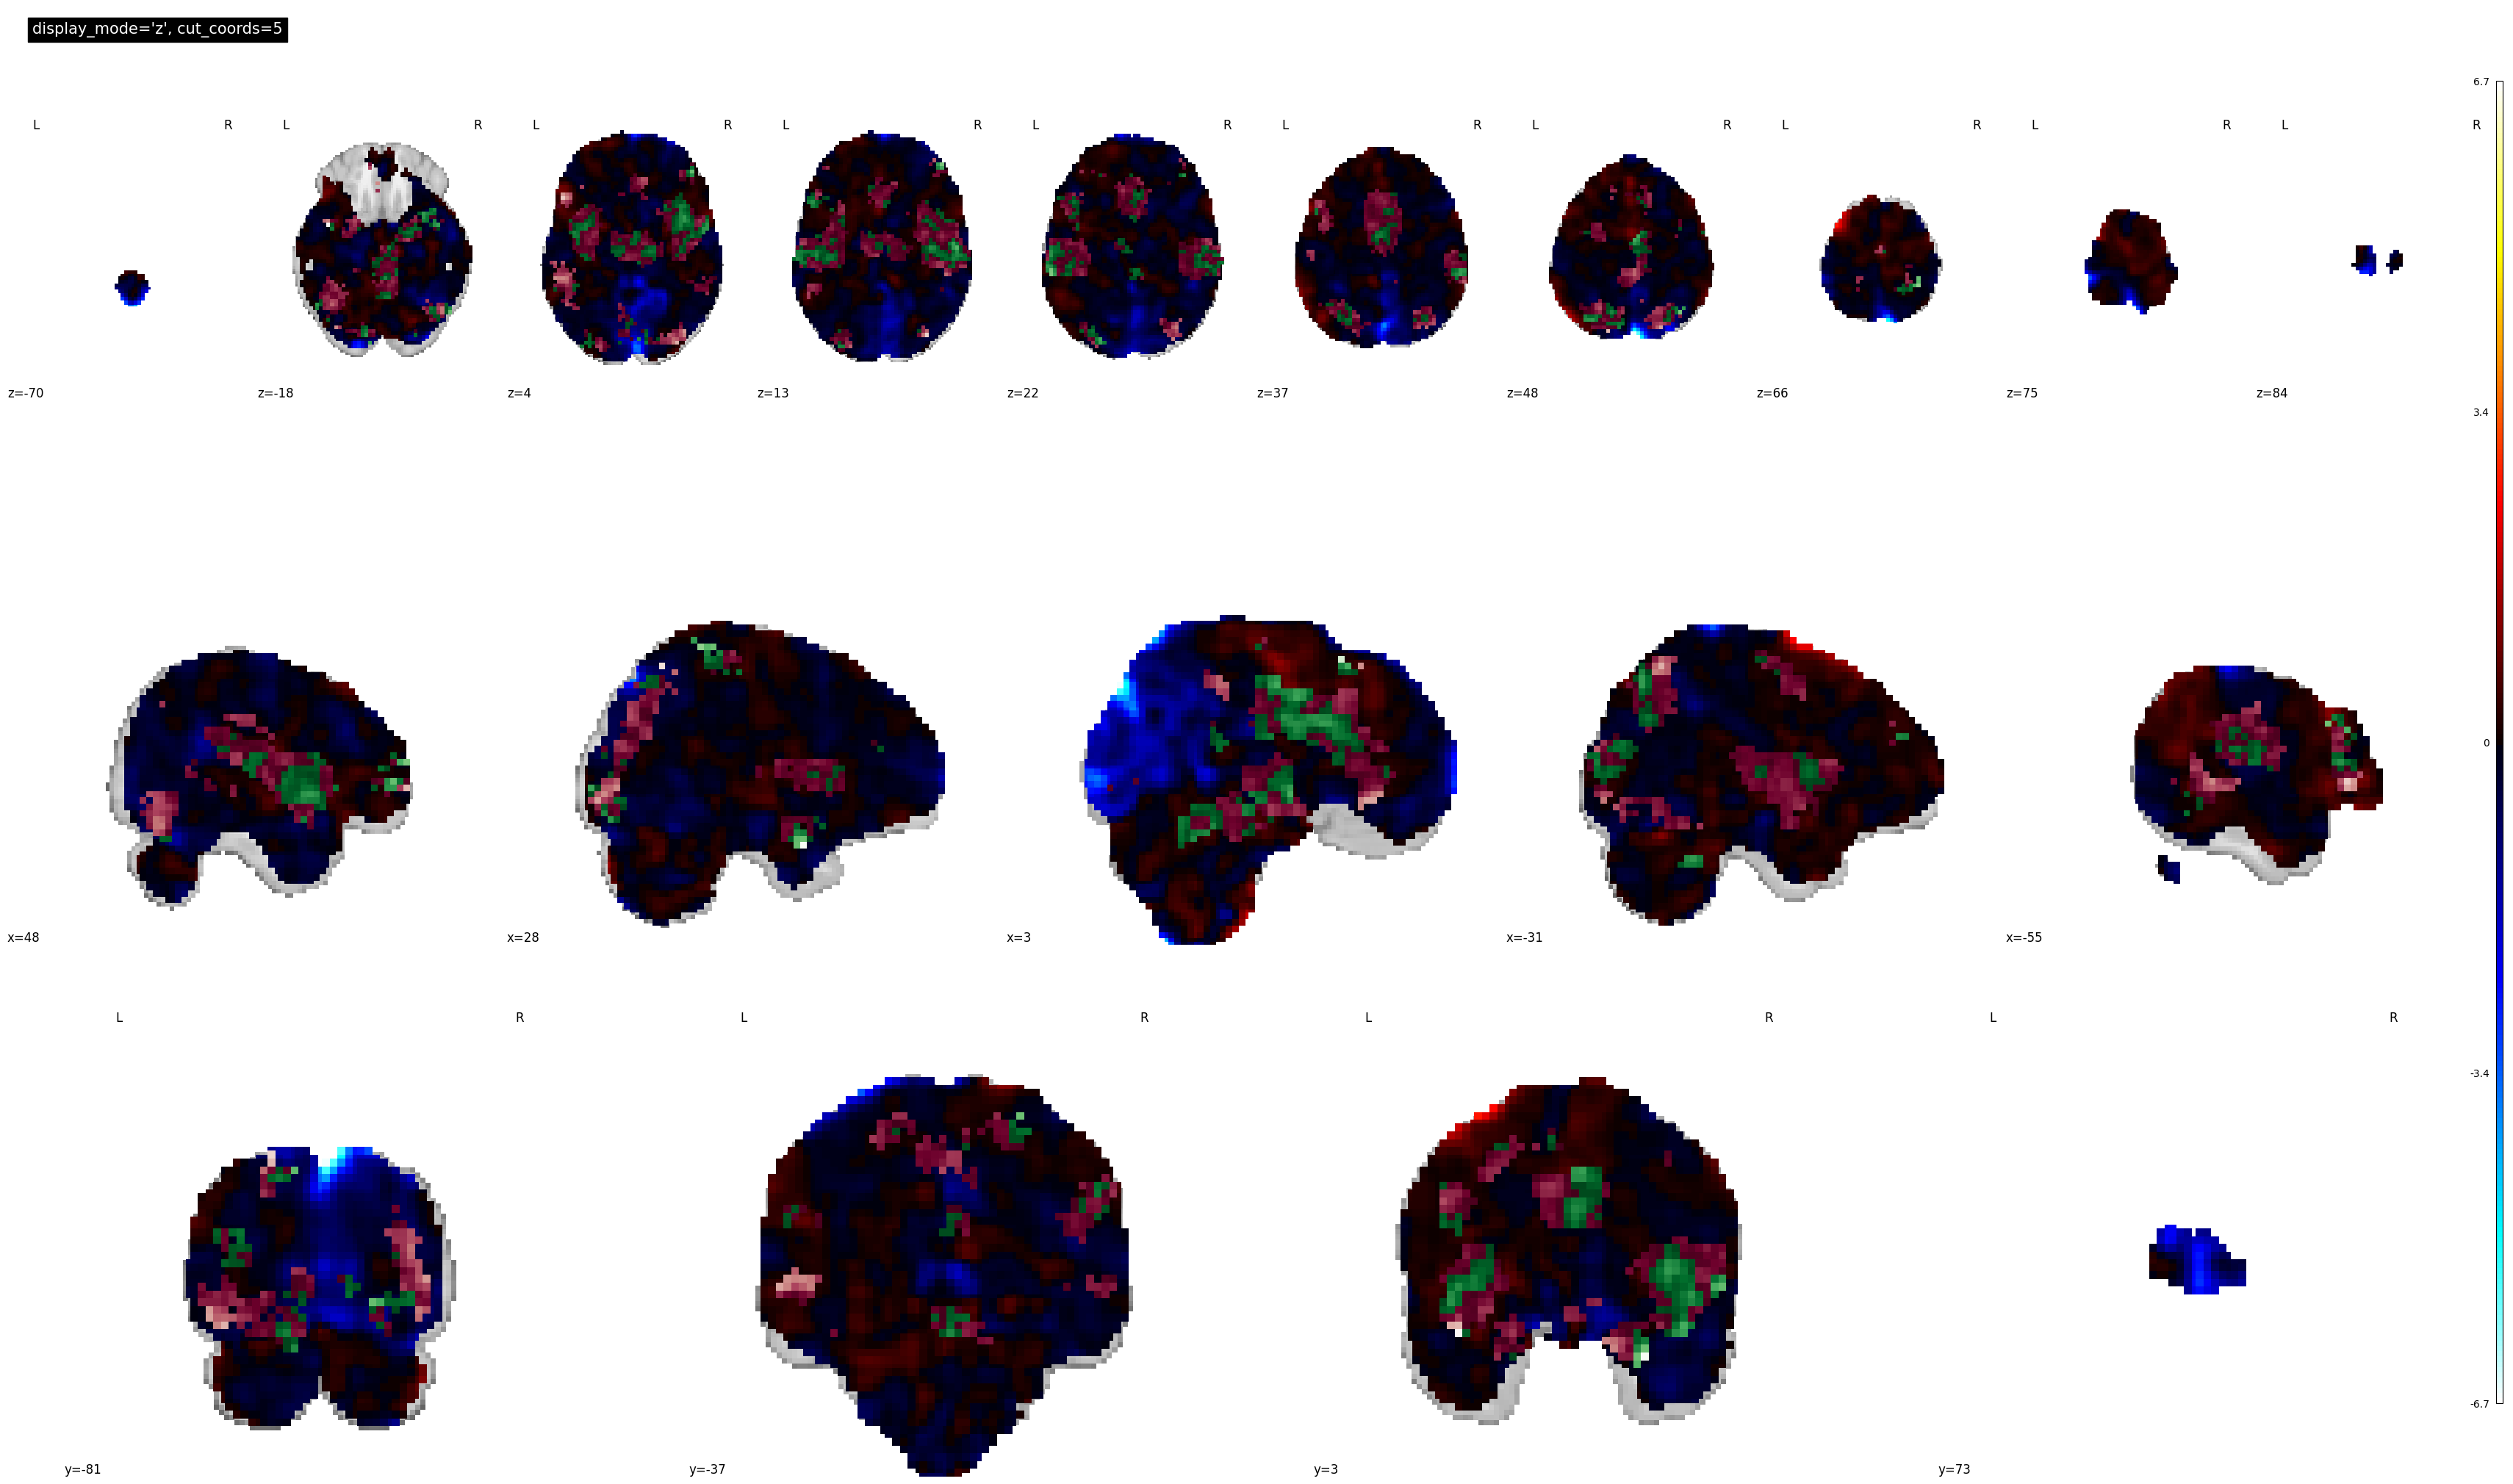

In [21]:
# # 3. resample space
# nps = '/Users/h/Documents/MATLAB/MasksPrivate/Masks_private/2013_Wager_NEJM_NPS/weights_NSF_grouppred_cvpcr.nii.gz'
# nps_img = image.load_img(nps)

# plotting.plot_stat_map(nps_img,display_mode='mosaic',
#                        cut_coords=(5, 4, 10),
#                        title="display_mode='z', cut_coords=5")
# plotting.plot_img(image.mean_img(stacked_singletrial))
# # %% resample space
# resampled_nps = image.resample_img(nps_img, 
#                                    target_affine = stacked_singletrial.affine, 
#                                    target_shape = stacked_singletrial.shape[0:3],
#                                    interpolation = 'continuous')

# %% check: plot resampled
display = plotting.plot_stat_map(image.mean_img(resampled_img),display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")
display.add_overlay(resampled_signature,cmap=plotting.cm.purple_green)



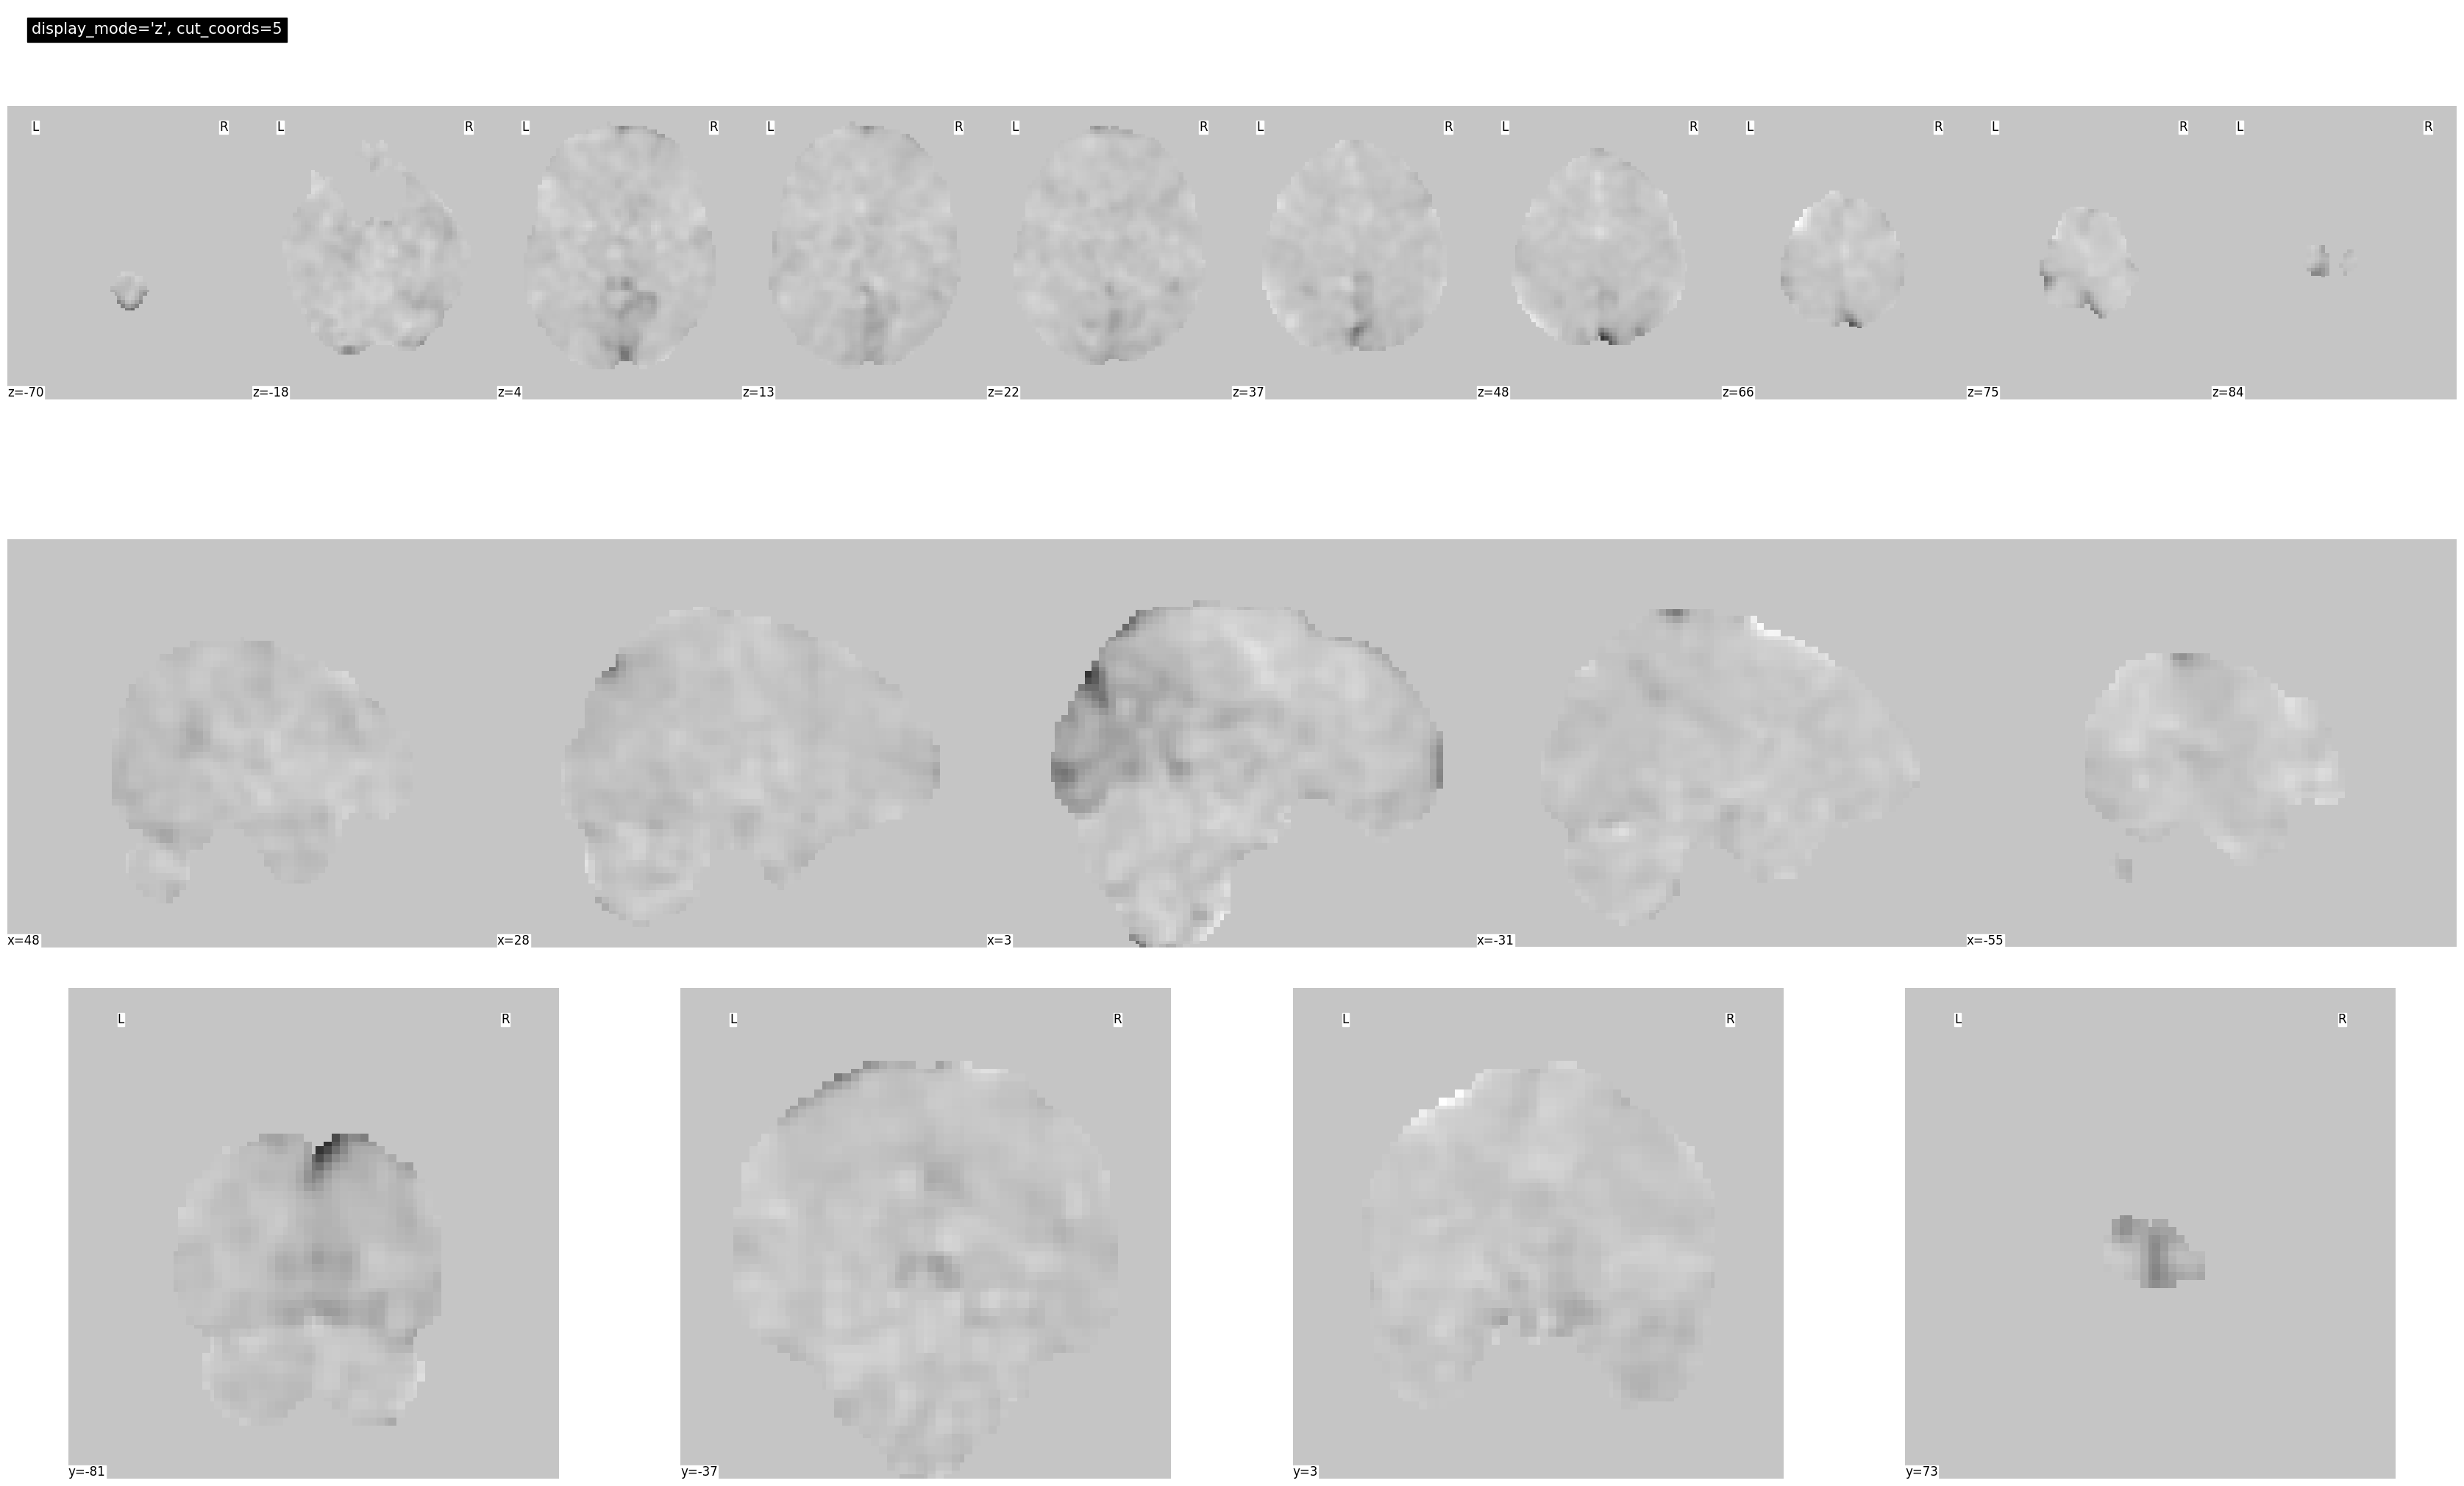

In [23]:
display = plotting.plot_anat(image.mean_img(resampled_img),display_mode='mosaic',
                       cut_coords=(5, 4, 10),
                       title="display_mode='z', cut_coords=5")